#1D_lineraly_Streteched_rod_with_introduced_body_force_(E=1)

Epoch 0, Loss: 0.032336484640836716
Epoch 100, Loss: 0.00031464529456570745
Epoch 200, Loss: 0.00012176908057881519
Epoch 300, Loss: 7.53565618651919e-05
Epoch 400, Loss: 5.21550391567871e-05
Epoch 500, Loss: 3.782523708650842e-05
Epoch 600, Loss: 2.8365375328576192e-05
Epoch 700, Loss: 2.186592246289365e-05
Epoch 800, Loss: 1.7258462321478873e-05
Epoch 900, Loss: 1.3903932995162904e-05
Epoch 1000, Loss: 1.1403702046663966e-05
Epoch 1100, Loss: 9.50087451201398e-06
Epoch 1200, Loss: 8.025343049666844e-06
Epoch 1300, Loss: 6.861677775304997e-06
Epoch 1400, Loss: 5.9299277381796855e-06
Epoch 1500, Loss: 5.173565114091616e-06
Epoch 1600, Loss: 1.733864155539777e-05
Epoch 1700, Loss: 4.104262643522816e-06
Epoch 1800, Loss: 3.88304306397913e-06
Epoch 1900, Loss: 3.371555294506834e-06


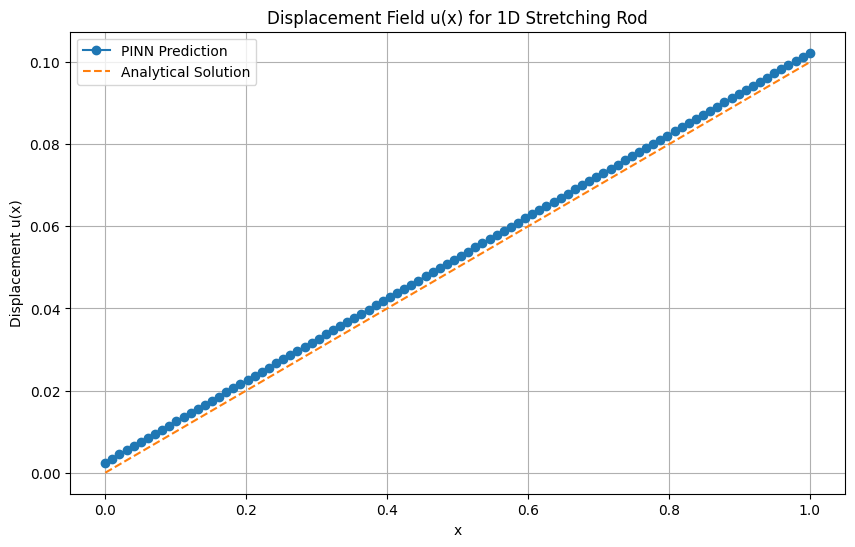

In [1]:
import numpy as np  # For numerical operations
import tensorflow as tf  # For building and training the neural network
import matplotlib.pyplot as plt  # For plotting results

# Define the Neural Network for solving the PDE
class SimplePINN(tf.keras.Model):
    def __init__(self, layer_sizes):
        super(SimplePINN, self).__init__()
        # Create hidden layers with 'tanh' activation
        self.hidden_layers = [tf.keras.layers.Dense(size, activation='tanh') for size in layer_sizes[:-1]]
        # Output layer (no activation function since this is a regression task)
        self.output_layer = tf.keras.layers.Dense(layer_sizes[-1])

    def call(self, x):
        # Pass data through each hidden layer
        for layer in self.hidden_layers:
            x = layer(x)
        # Return the result from the output layer
        return self.output_layer(x)

# Function to compute PDE residual (difference from satisfying the equation)
def compute_pde_residual(model, x_vals, young_modulus):
    # Use nested gradient tapes to calculate second derivatives (needed for PDE residual)
    with tf.GradientTape(persistent=True) as outer_tape:
        with tf.GradientTape() as inner_tape:
            inner_tape.watch(x_vals)
            outer_tape.watch(x_vals)
            predicted_u = model(x_vals)  # Predict displacement using model

        # First derivative of displacement (strain)
        u_x = inner_tape.gradient(predicted_u, x_vals)
        # Compute stress using Hooke's Law (stress = modulus * strain)
        stress = young_modulus * u_x

    # Second derivative of stress (needed for the PDE residual)
    stress_x = outer_tape.gradient(stress, x_vals)
    del inner_tape, outer_tape  # Clean up tapes after use

    return stress_x  # Return the computed PDE residual (difference from zero)

# Loss function to enforce the PDE residual and boundary conditions
def compute_total_loss(model, x_points, x_left, x_right, young_modulus, force):
    # Calculate PDE residual loss
    pde_loss = tf.reduce_mean(tf.square(compute_pde_residual(model, x_points, young_modulus)))
    # Enforce boundary condition at the left end (displacement u = 0 at x = 0)
    left_boundary_loss = tf.reduce_mean(tf.square(model(x_left)))
    # Enforce boundary condition at the right end (displacement u = t / E at x = 1)
    right_boundary_loss = tf.reduce_mean(tf.square(model(x_right) - force / young_modulus))
    # Total loss combines PDE residual and boundary conditions
    return pde_loss + left_boundary_loss + right_boundary_loss

# Create points to check the PDE (collocation points) and boundary points
num_collocation_points = 100
x_points = tf.convert_to_tensor(np.linspace(0, 1, num_collocation_points).reshape(-1, 1), dtype=tf.float32)
x_left = tf.convert_to_tensor([[0.0]], dtype=tf.float32)
x_right = tf.convert_to_tensor([[1.0]], dtype=tf.float32)

# Model parameters
young_modulus = 10  # Young's modulus, E
force = 1  # Force applied at the end of the rod
layer_sizes = [1, 20, 20, 20, 1]  # Neural network structure: 1 input, 3 hidden layers, 1 output

# Initialize the neural network model
model = SimplePINN(layer_sizes)

# Set up the optimizer for training
optimizer = tf.keras.optimizers.Adam()

# Training loop
num_epochs = 2000
for epoch in range(num_epochs):
    # Record gradients with respect to model parameters
    with tf.GradientTape() as tape:
        # Compute total loss (PDE residual + boundary conditions)
        loss = compute_total_loss(model, x_points, x_left, x_right, young_modulus, force)
    # Compute gradients of loss with respect to model parameters
    gradients = tape.gradient(loss, model.trainable_variables)
    # Update model weights using gradients
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Print the loss every 100 epochs for monitoring
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Evaluate the model by generating predictions for test points
x_test = tf.convert_to_tensor(np.linspace(0, 1, 100).reshape(-1, 1), dtype=tf.float32)
predicted_u = model(x_test)  # Predicted displacement values

# Calculate the analytical solution for comparison
x_true = np.linspace(0, 1, 100)
true_u = (force / young_modulus) * x_true  # u(x) = (t / E) * x

# Plot the model's predictions and the analytical solution
plt.figure(figsize=(10, 6))
plt.plot(x_test, predicted_u, label="PINN Prediction", linestyle='-', marker='o')
plt.plot(x_true, true_u, label="Analytical Solution", linestyle='--')
plt.xlabel("x")
plt.ylabel("Displacement u(x)")
plt.title("Displacement Field u(x) for 1D Stretching Rod")
plt.legend()
plt.grid()
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'pinn', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Epoch 0, Loss: 2.1505513191223145
Epoch 500, Loss: 0.0775962620973587
Epoch 1000, Loss: 0.06997445225715637
Epoch 1500, Loss: 0.030236031860113144
Epoch 2000, Loss: 0.0069174617528915405
Epoch 2500, Loss: 0.0027424923609942198
Epoch 3000, Loss: 0.0006284067640081048
Epoch 3500, Loss: 0.0002152338420273736
Epoch 4000, Loss: 0.00015700410585850477
Epoch 4500, Loss: 0.00012040235742460936
Epoch 5000, Loss: 8.601861918577924e-05
Epoch 5500, Loss: 5.94029770581983e-05


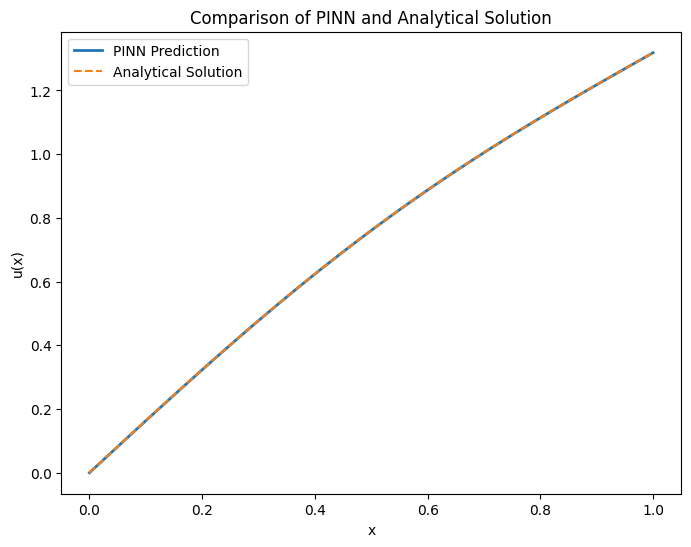

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Constants
EA = 1  # Stiffness coefficient (assume EA=1 for simplicity)
pi = np.pi

# Analytical Solution
def analytical_solution(x):
    return (1 / (pi**2 * EA)) * np.sin(pi * x) + (1 + 1 / pi) * x

# Define the governing equation as a loss function
def pinn_loss(model, x):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        u = model(x)
        u_x = tape.gradient(u, x)
    u_xx = tape.gradient(u_x, x)
    del tape

    f = EA * u_xx + tf.sin(pi * x)  # Governing equation
    return tf.reduce_mean(tf.square(f))

# Boundary condition loss
def boundary_loss(model):
    # Boundary at x = 0
    x0 = tf.convert_to_tensor([[0.0]])
    u0 = model(x0)

    # Boundary at x = 1 (force boundary condition)
    x1 = tf.convert_to_tensor([[1.0]])
    with tf.GradientTape() as tape:
        tape.watch(x1)
        u1 = model(x1)
    u1_x = tape.gradient(u1, x1)

    force_condition = EA * u1_x - 1  # F = EA * du/dx
    return tf.reduce_mean(tf.square(u0)) + tf.reduce_mean(tf.square(force_condition))

# Total loss function
def total_loss(model, x):
    return pinn_loss(model, x) + boundary_loss(model)

# Define the neural network
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = [tf.keras.layers.Dense(30, activation='tanh')] #for _ in range(3)
        self.hidden_layers = [tf.keras.layers.Dense(30, activation='tanh')]
        self.hidden_layers = [tf.keras.layers.Dense(30, activation='tanh')]
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

# Generate training data
x_train = tf.convert_to_tensor(np.linspace(0, 1, 100).reshape(-1, 1), dtype=tf.float32)

# Initialize the model
model = PINN()

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
epochs = 6000
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        loss = total_loss(model, x_train)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Evaluate the model
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
x_test_tensor = tf.convert_to_tensor(x_test, dtype=tf.float32)
u_pred = model(x_test_tensor).numpy()

# Analytical solution
u_analytical = analytical_solution(x_test)

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(x_test, u_pred, label='PINN Prediction', linewidth=2)
plt.plot(x_test, u_analytical, label='Analytical Solution', linestyle='dashed')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.title('Comparison of PINN and Analytical Solution')
plt.show()
